In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from mpmath import besseljzero
from scipy.special import gamma
from scipy.special import jv, iv, ive
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_CDDM(ub, lb, delta, mu_z, sigma_z, ndt=0, corr='noise', z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
    
    if corr == 'noise':
        return (rt+ndt)*ch, np.random.normal(mu_z, sigma_z)
    else:
        return (rt+ndt)*ch, np.random.normal(ndt, sigma_z)

In [3]:
def f(x, t, z, tau, delta, sigma=1):
    term1 = 1/np.sqrt(2 * np.pi * sigma**2 * (t-tau))
    term2 = -(x - z - delta * (t-tau))**2 / (2 * sigma**2 * (t-tau))
    return term1 * np.exp(term2)

def psi(b, db, t, z, tau, delta, sigma=1):
    term1 = 0.5*f(b(t), t, z, tau, delta, sigma)
    term2 = db(t) - delta - (b(t) - z - delta * (t-tau))/(t-tau)
    return term1 * term2

def fpt(ub, lb, dub, dlb, delta, z=0, sigma=1, dt=0.01, T_max=5):
    gu = [0]
    gl = [0]
    T = [0]
    
    gu.append(-2*psi(ub, dub, dt, z, 0, delta, sigma))
    gl.append( 2*psi(lb, dlb, dt, z, 0, delta, sigma))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        su = -2 * psi(ub, dub, n*dt, z, 0, delta, sigma)
        sl =  2 * psi(lb, dlb, n*dt, z, 0, delta, sigma)
        
        for j in range(1, n):
            if ub(j*dt) == 0:
                continue
            
            psi_n_j_pp = psi(ub, dub, n*dt, ub(j*dt), j*dt, delta, sigma)
            psi_n_j_pn = psi(ub, dub, n*dt, lb(j*dt), j*dt, delta, sigma)
            psi_n_j_np = psi(lb, dlb, n*dt, ub(j*dt), j*dt, delta, sigma)
            psi_n_j_nn = psi(lb, dlb, n*dt, lb(j*dt), j*dt, delta, sigma)
            
            su +=  2 * dt * (gu[j] * psi_n_j_pp + gl[j] * psi_n_j_pn)
            sl += -2 * dt * (gu[j] * psi_n_j_np + gl[j] * psi_n_j_nn)
            
        gu.append(su)
        gl.append(sl)
        T.append(n*dt)
        
    gu = np.asarray(gu)
    gl = np.asarray(gl)
    T = np.asarray(T)
    
    gtu = interp1d(T, gu)
    gtl = interp1d(T, gl)
    return gtu, gtl

In [4]:
def CDDM_likelihood(prms, RT, Z):
    ub = lambda t: prms[0] * np.exp(-prms[1]*t)
    lb = lambda t: -1*ub(t)
    dub = lambda t: -prms[1] * prms[0] * np.exp(-prms[1]*t)
    dlb = lambda t: -1*dub(t)

    delta = prms[2]
    sig = prms[3]
    t0 = prms[4]
    
    T_max = np.max(np.abs(RT))
    gtup, gtlp = fpt(ub, lb, dub, dlb, delta, z=0, dt=0.05, T_max=T_max)
#     gtun, gtln = fpt(ub, lb, dub, dlb, -delta, z=0, dt=0.05, T_max=T_max)
    
    ll = 0
    for i in range(len(RT)):
        if np.abs(RT[i])-t0 > 0:
            if RT[i]>=0:
                
                ll += 0.5*(Z[i] - t0)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2)
                
                if gtup(RT[i])>1e-14:
                    ll += -np.log(gtup(np.abs(RT[i])-t0))
                else:
                    ll += -np.log(1e-14)
            else:
                
                ll += + 0.5*(Z[i] - t0)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2)
                
                if gtlp(np.abs(RT[i])-t0)>1e-14:
                    ll += -np.log(gtlp(np.abs(RT[i])-t0))
                else:
                    ll += -np.log(1e-14) 
        else:
            ll += -np.log(1e-14)
    
    return ll

In [5]:
recovery_dic = {'a_true': [],
                'a_estimate': [],
                'lambda_true': [],
                'lambda_estimate': [],
                'delta_true': [],
                'delta_estimate': [],
                'sigma_true':[],
                'sigma_estimate':[],
                'ndt_true':[],
                'ndt_estimate':[],
                'mu_z':[],
                'std_z':[],
                'corr':[]}

min_b0 = 2
max_b0 = 5

min_lambda = .1
max_lambda = 2

min_ndt = 0.1
max_ndt = 1

min_mu = -3
max_mu = 3

In [35]:
for n in tqdm(range(25)):
    threshold = np.random.uniform(1.5, 4)
    lamda = np.random.uniform(0.1, 2)
    delta = np.random.uniform(0, 3)
    sigma_z = np.random.uniform(0.05, 1)
    ndt = np.random.uniform(0.05, 1)
    
    mu_z = np.random.uniform(0.05, 3)
    while np.abs(mu_z - ndt)<.5:
        mu_z = np.random.uniform(0.05, 3)
    
    ub = lambda t: threshold * np.exp(-lamda*t)
    lb = lambda t: -1*ub(t)
    
    RT = []
    Z = []
    if np.random.random()<0.5:
        corr = 'noise'
        for i in range(500):
            rt, z = simulate_CDDM(ub, lb, delta, mu_z, sigma_z, ndt=ndt, corr=corr)
            RT.append(rt)
            Z.append(z)
    else:
        corr = 'ndt'
        for i in range(500):
            rt, z = simulate_CDDM(ub, lb, delta, mu_z, sigma_z, ndt=ndt, corr=corr)
            RT.append(rt)
            Z.append(z)
        
    RT = np.array(RT)
    Z = np.array(Z)
    
    ans_cddm = differential_evolution(CDDM_likelihood,
                                      args=(RT, Z), 
                                      bounds=[(1.5, 4), (0.1, 2), (0, 3), 
                                              (0.05, 5), (0.05, 1)])
    ans_cddm = minimize(CDDM_likelihood,
                        args=(RT, Z),
                        method='Nelder-Mead',
                        x0=ans_cddm.x,
                        bounds=[(1.5, 4), (0.1, 2), (0, 3), 
                                (0.05, 5), (0.05, 1)])

    recovery_dic['a_true'].append(threshold)
    recovery_dic['a_estimate'].append(ans_cddm.x[0])
    recovery_dic['lambda_true'].append(lamda)
    recovery_dic['lambda_estimate'].append(ans_cddm.x[1])
    recovery_dic['delta_true'].append(delta)
    recovery_dic['delta_estimate'].append(ans_cddm.x[2])
    recovery_dic['sigma_true'].append(sigma_z)
    recovery_dic['sigma_estimate'].append(ans_cddm.x[3])
    recovery_dic['ndt_true'].append(ndt)
    recovery_dic['ndt_estimate'].append(ans_cddm.x[4])
    recovery_dic['mu_z'].append(mu_z)
    recovery_dic['std_z'].append(np.std(Z))
    recovery_dic['corr'].append(corr)

100%|█████████████████████████████████████████| 25/25 [38:03<00:00, 91.35s/it]


In [36]:
recovery_df = pd.DataFrame(recovery_dic)
recovery_df['sig_to_var'] = recovery_df['sigma_estimate']/recovery_df['std_z']
recovery_df

,a_true,a_estimate,lambda_true,lambda_estimate,delta_true,delta_estimate,sigma_true,sigma_estimate,ndt_true,ndt_estimate,mu_z,std_z,corr,sig_to_var
0,3.037307,3.532921,0.996219,1.071659,2.475571,2.479314,0.508626,0.487603,0.559905,0.519905,1.840412,0.487562,ndt,1.000083
1,2.708445,2.522924,1.101216,1.020331,0.370228,0.374072,0.238794,0.253525,0.341460,0.331637,2.806677,0.253511,ndt,1.000057
2,3.997595,4.000000,1.552122,1.521979,1.022535,1.000674,0.129385,0.128869,0.457928,0.467383,2.298931,0.128862,ndt,1.000058
3,1.852142,1.960132,0.435310,0.415468,1.468229,1.496344,0.106781,0.104816,0.159752,0.161410,2.690681,0.104816,ndt,1.000002
4,3.276006,3.101360,0.878730,0.811780,2.022522,2.183985,0.745504,0.745005,0.753162,0.801162,2.389392,0.745005,ndt,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,3.771464,3.683021,0.314806,0.194990,1.679946,1.985455,0.820742,0.819763,0.888682,0.902684,1.779702,0.819744,ndt,1.000022
71,1.980565,1.504068,0.252539,0.125298,1.460091,1.532200,0.708967,2.052677,0.718010,0.860968,2.764893,0.700552,noise,2.930083
72,3.276790,3.610189,1.089492,1.124066,2.895865,2.999988,0.144913,0.150730,0.172179,0.164179,1.285536,0.150722,ndt,1.000054
73,2.878214,3.182836,1.927016,2.000000,1.848149,1.822945,0.331811,0.338344,0.984763,0.974794,2.123263,0.338339,ndt,1.000013


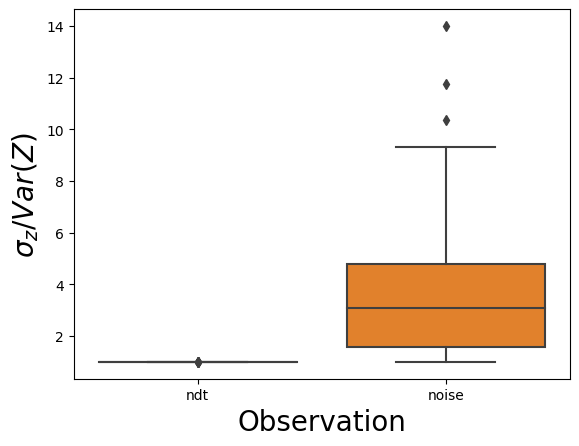

In [37]:
sns.boxplot(x='corr', y='sig_to_var', data=recovery_df);
plt.xlabel('Observation', fontsize=20)
plt.ylabel(r'$\sigma_{z}/Var(Z)$', fontsize=20);

In [38]:
recovery_df.groupby(by='corr')['sig_to_var'].min()['noise']

1.000078577027756

In [39]:
recovery_df.groupby(by='corr')['sig_to_var'].max()['ndt']

1.0017361986304887

In [40]:
recovery_df.to_csv('Exponential_rec.csv')